# **Random Forest**: *Forecasting 30 days time step Closing Price given past 30 days data*

In [ ]:
import csv
import random
import math
import operator
import pandas_datareader as web
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import asarray
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

1. **Importing of data**

In [ ]:
def get_dataframe(stock_name , country):
  df = pd.read_csv(f'{stock_name}.{country}.txt', index_col=0)
  df.drop('OpenInt', inplace=True, axis=1) # remove OpenInt column
  return df


2. **Visulizing Data Set**

In [ ]:
def plot_graph(dataframe, stock_name):
    plt.title(f'Close price history of {stock_name.upper()}')
    plt.plot(dataframe['Close'])
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.xticks([list(dataframe.index.values)[0], list(dataframe.index.values)[-1]])
    plt.show()

3. **Feature Engineering**

In [ ]:
def feature_engineering(data):
  df = DataFrame(data)

  #percentage change with respect to open
  df_new = df.loc[:,['Open','Close','Volume','High', 'Low']]
  df_new['Relative High'] = (df['High']-df['Open']/df['Open'])
  df_new['Relative Low'] = (df['Low']-df['Open']/df['Open'])
  df_new['Relative Close'] = (df['Close']-df['Open']/df['Open'])

  return df_new

4. **Spiting Data into Training and Test Set**

In [ ]:
def split_data(data, ratio):
    num_of_data = data.shape[0]
    num_of_training = round(num_of_data * ratio)
    num_of_testing = num_of_data - num_of_training  


    return data[:-num_of_testing], data[-num_of_testing:]

5. **Converting Time Series Data for Supervised Learning**

In [ ]:
def convert_data(data, time_step_history, time_step_forecast):
    df_con = DataFrame()

    cols = []
    headers = ['Relative High', 'Relative Low', 'Relative Close','Volume', 'Open']

    for i in range(0,time_step_history+1):
      for j in range(0, len(headers)):
          c = headers[j]
          # print(headers)
          header = f'{c}(t-{i})'
          df_con[header] = data[c].shift(i)
          cols.append(header)

    df_con['Close'] = data['Close']
    label = f'C(t+{time_step_forecast})'
    df_con[label] = data['Close'].shift(-time_step_forecast) / data['Close']

    label_classify = f'C(t+{time_step_forecast}) Classification'
    c = data['Close'].shift(-time_step_forecast) - data['Close']

    df_con['Return'] = data['Close'] - data['Close'].shift(time_step_history) - data['Close']
    
    for i in range(0, len(c)):
        if c[i] > 0:
            c[i] = 1
        else:
            c[i] = 0           
    
    df_con[label_classify] = pd.Series(c).values

    cols.append(label)
    df_con.dropna(inplace=True)
    return df_con



5. **Training Random Forest Model**

In [ ]:
def split_input_label(data, time_step_forecast):

    label = DataFrame()
    label['Close'] = data['Close']
    temp = f'C(t+{time_step_forecast})'
    label[temp] = data[temp]
    tempC = f'C(t+{time_step_forecast}) Classification'
    label['Close Classification'] = data[tempC]
    input = data.drop(['Close', temp, tempC], axis = 1)

    return input, label


def train_random_forest(input, label, tsf):
  train_x = asarray(input)
  train_y = asarray(label[f'C(t+{tsf})'])
  model = RandomForestRegressor(n_estimators=1000)
  rfm = model.fit(train_x,train_y)
  return rfm

def train_random_forest_class(input, label, tsf):
  train_x = asarray(input)
  train_y = asarray(label["Close Classification"])
  model = RandomForestClassifier(n_estimators=1000)
  rfm = model.fit(train_x,train_y)
  return rfm

6. **Evaluation**

In [ ]:
def model_predict(model, input_x, label_y, name, f):
  predict = model.predict(asarray(input_x))
  data = DataFrame()
  data['Close'] = label_y['Close']
  data['Prediction'] = predict * label_y['Close']
  data['Actual Close'] = label_y[f'C(t+{f})'] * label_y['Close']
  data['Predicted Close'] = data['Prediction']
  plt.title(f'Prediction on {name}')
  plt.plot(data['Actual Close'], label='Actual')
  plt.plot(data['Predicted Close'], label='Predicted', alpha=0.5)
  plt.xlabel('Date')
  plt.ylabel('Close Price USD ($)')
  plt.xticks([list(data.index.values)[0], list(data.index.values)[-1]])
  plt.legend()
  plt.show()
  plt.savefig(f"{name} (t+{f})", transparent=True)


  mse = mean_squared_error(asarray(data['Actual Close']), asarray(data['Predicted Close']))
  print(f"mse value = {mse}")
  rmse = math.sqrt(mse)
  print(f"mse value = {rmse}")

  return data

# train_data = model_predict(model, input, label, "Training Set", time_step_forecast)
# test_data = model_predict(model, test_input, test_label, "Testing Set", time_step_forecast)


In [ ]:
col_names = ["Accuracy", "Recall", "Precision", "F-Score", "Average Gain"]
table = DataFrame(columns = col_names)

def count(bitmap):
    result = 0

    for temp in bitmap:
        result = result + temp  

    return result      



In [ ]:
def classify(data, tsf, name):
    copy = data.copy()
    copy['Predicted Direction'] = data['Prediction']
    copy['Actual Direction'] = data['Close Classification']

    copy['Close(t)'] = data['Close']
    copy[f'C(t+{tsf})'] = data[f'C(t+{tsf})']
    
    gain = np.where( copy["Predicted Direction"] == 1 , copy[f'C(t+{tsf})']*copy['Close(t)'] - copy['Close(t)'], 0)

    expected_gain = 0
    num = 0

    for temp in gain:
        if temp != 0:
            num = num + 1
        expected_gain = temp + expected_gain

    
    expected_gain = expected_gain/num

    accuracy = metrics.accuracy_score(copy['Actual Direction'],copy['Predicted Direction'])
    recall = metrics.recall_score(copy['Actual Direction'],copy['Predicted Direction'])
    precision = metrics.precision_score(copy['Actual Direction'],copy['Predicted Direction'])
    fscore = metrics.f1_score(copy['Actual Direction'],copy['Predicted Direction'])
    
    print(f"accuracy : {accuracy}")
    print(f"recall : {recall}")
    print(f"precision : {precision}")
    print(f"fscore : {fscore}")
    print(f"average expected gain : {expected_gain}")

    table.loc[f"{name} (t+{tsf})"] = [accuracy, recall, precision, fscore, expected_gain]

def train_on_stock(name, split, tsh, tsf):

    print(f"Training on : stock name: {name}, split: {split}, time step history: t-{tsh}, time step future: t+{tsf}\n")
    stock = name
    country = 'us' 
    df = get_dataframe(stock , country)
    df.tail() 
    plot_graph(df, stock)  
    new_df = feature_engineering(df)
    train_set, test_set = split_data(new_df, split)
    time_step_history = tsh
    time_step_forecast = tsf
    df_converted_train = convert_data(train_set, time_step_history, time_step_forecast)

    df_converted_test = convert_data(test_set, time_step_history, time_step_forecast)

    input, label = split_input_label(df_converted_train, time_step_forecast)
    model_class = train_random_forest_class(input, label, tsf)
    print("training...")
    model = train_random_forest(input, label, tsf)
    test_input , test_label = split_input_label(df_converted_test, time_step_forecast) 

    print("\n\nRegression\n\n")
    model_predict(model, input, label, f"Training Set: {name}", tsf)
    model_predict(model, test_input, test_label, f"Testing Set :{name}", tsf)

    print("\n\nCLASSIFICATION\n\n")
    predict = model_class.predict(asarray(test_input))
    test_label["Prediction"] = predict
    classify(test_label, tsf, name)
    print(f"stock name: {name}, split: {split}, time step history: t-{tsh}, time step future: t+{tsf}\n")

### **1. APPL REGRESSION**

Training on : stock name: aapl, split: 0.8, time step history: t-5, time step future: t+1



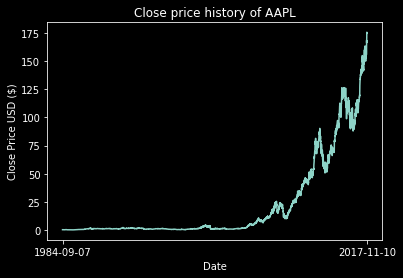

training...


Regression




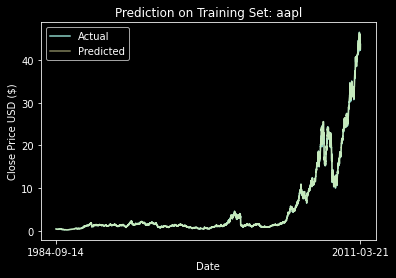

mse value = 0.00664327152590436
mse value = 0.08150626678915161


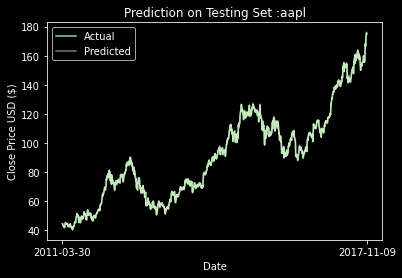

mse value = 2.1464857961472954
mse value = 1.4650890062202007


CLASSIFICATION


accuracy : 0.4829034193161368
recall : 0.050808314087759814
precision : 0.5238095238095238
fscore : 0.09263157894736843
average expected gain : 0.18345238095238076
stock name: aapl, split: 0.8, time step history: t-5, time step future: t+1

Training on : stock name: aapl, split: 0.8, time step history: t-5, time step future: t+5



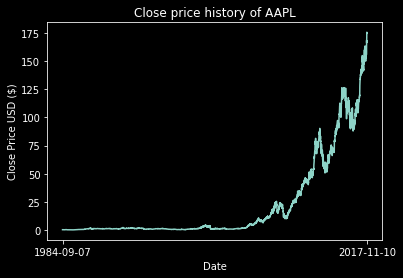

training...


Regression




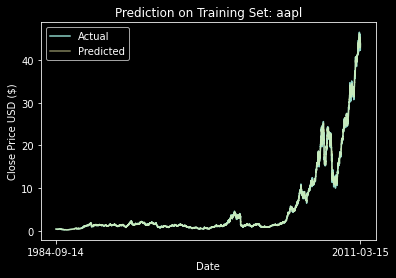

mse value = 0.02290776567591914
mse value = 0.15135311584476593


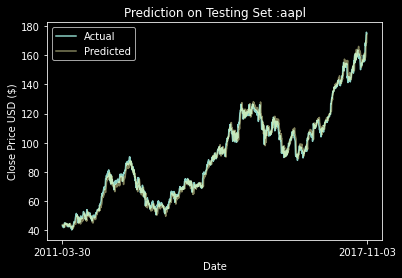

mse value = 11.122442645876806
mse value = 3.335032630406606


CLASSIFICATION


accuracy : 0.44738424533974747
recall : 0.03559870550161812
precision : 0.5689655172413793
fscore : 0.06700507614213198
average expected gain : 0.3603793103448271
stock name: aapl, split: 0.8, time step history: t-5, time step future: t+5

Training on : stock name: aapl, split: 0.8, time step history: t-5, time step future: t+30



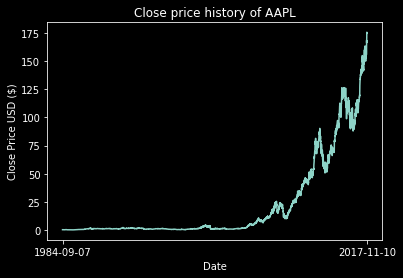

training...


Regression




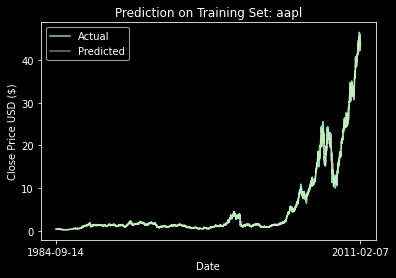

mse value = 0.11429172908555531
mse value = 0.3380705977832963


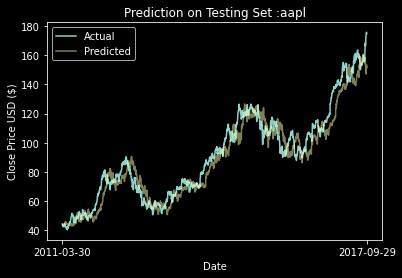

mse value = 72.42121607013551
mse value = 8.510065573785875


CLASSIFICATION


accuracy : 0.394993894993895
recall : 0.10753768844221105
precision : 0.5095238095238095
fscore : 0.17759336099585063
average expected gain : 0.2118047619047606
stock name: aapl, split: 0.8, time step history: t-5, time step future: t+30



<Figure size 432x288 with 0 Axes>

In [ ]:
stock = "aapl"
train_on_stock(stock, 0.8, 5, 1)
train_on_stock(stock, 0.8, 5, 5)
train_on_stock(stock, 0.8, 5, 30)

### **2. MIK REGRESSION**

Training on : stock name: mik, split: 0.8, time step history: t-5, time step future: t+1



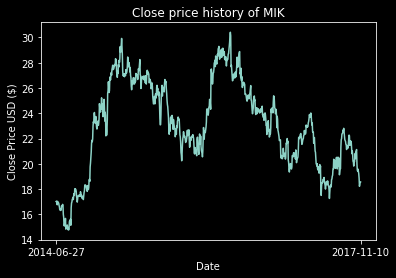

training...


Regression




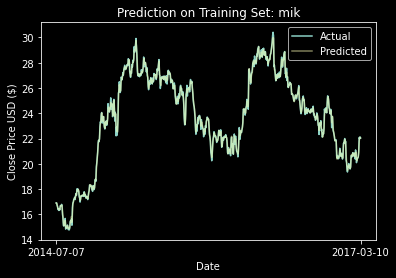

mse value = 0.03059381974895703
mse value = 0.1749108908814915


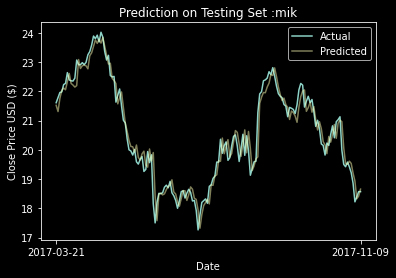

mse value = 0.15784504044394762
mse value = 0.39729716893522865


CLASSIFICATION


accuracy : 0.47560975609756095
recall : 0.43023255813953487
precision : 0.5
fscore : 0.46249999999999997
average expected gain : -0.016111111111111163
stock name: mik, split: 0.8, time step history: t-5, time step future: t+1

Training on : stock name: mik, split: 0.8, time step history: t-5, time step future: t+5



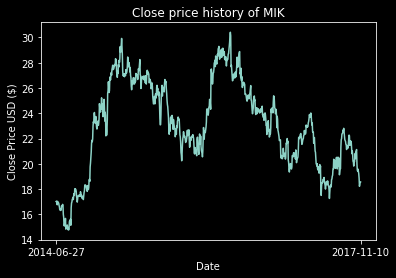

training...


Regression




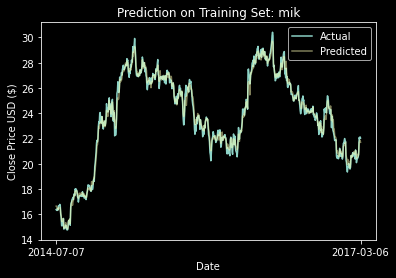

mse value = 0.1041702962977658
mse value = 0.32275423513528956


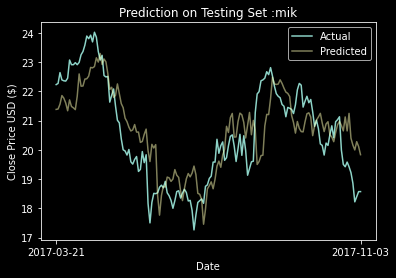

mse value = 1.0694039223382368
mse value = 1.034119878127404


CLASSIFICATION


accuracy : 0.5375
recall : 0.5675675675675675
precision : 0.5
fscore : 0.5316455696202531
average expected gain : 0.0002409638554216816
stock name: mik, split: 0.8, time step history: t-5, time step future: t+5

Training on : stock name: mik, split: 0.8, time step history: t-5, time step future: t+30



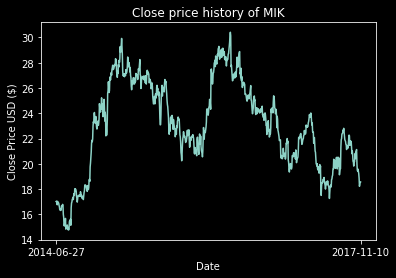

training...


Regression




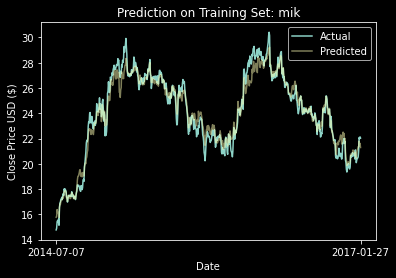

mse value = 0.3898360324361139
mse value = 0.6243685069220851


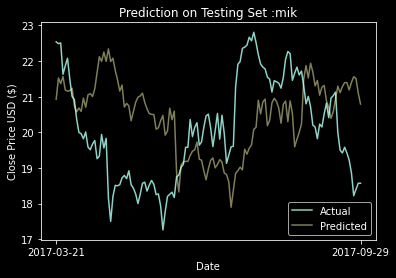

mse value = 3.39936756686802
mse value = 1.843737390971941


CLASSIFICATION


accuracy : 0.8666666666666667
recall : 0.9333333333333333
precision : 0.8
fscore : 0.8615384615384616
average expected gain : 1.2205714285714286
stock name: mik, split: 0.8, time step history: t-5, time step future: t+30



<Figure size 432x288 with 0 Axes>

In [ ]:
stock = "mik"
train_on_stock(stock, 0.8, 5, 1)
train_on_stock(stock, 0.8, 5, 5)
train_on_stock(stock, 0.8, 5, 30)

### **3. YPF REGRESSION**

Training on : stock name: ypf, split: 0.8, time step history: t-5, time step future: t+1



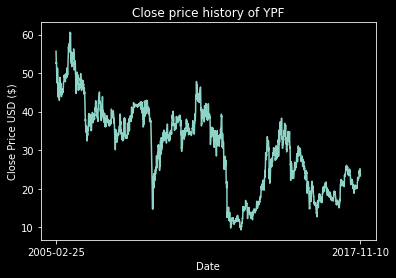

training...


Regression




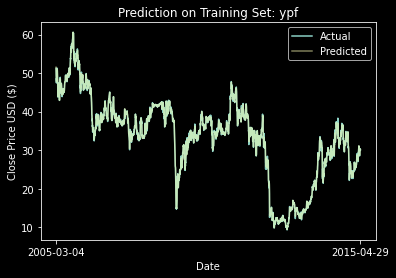

mse value = 0.09328648540254722
mse value = 0.3054283637819959


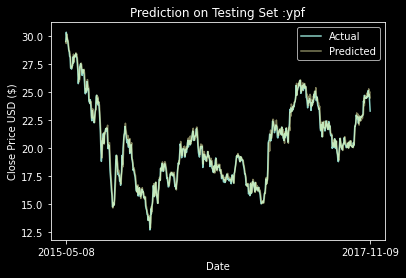

mse value = 0.24978670415222773
mse value = 0.49978665863769084


CLASSIFICATION


accuracy : 0.5189274447949527
recall : 0.6722408026755853
precision : 0.49264705882352944
fscore : 0.5685997171145687
average expected gain : -0.0030148514851484707
stock name: ypf, split: 0.8, time step history: t-5, time step future: t+1

Training on : stock name: ypf, split: 0.8, time step history: t-5, time step future: t+5



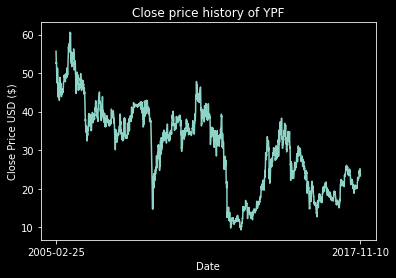

training...


Regression




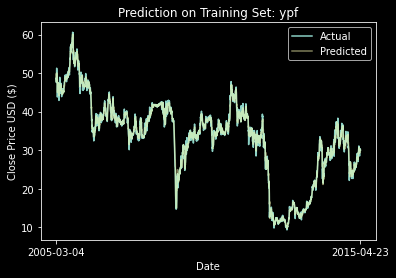

mse value = 0.41113965167510963
mse value = 0.6412017246351648


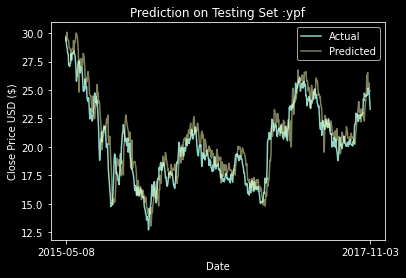

mse value = 1.9322667758544763
mse value = 1.3900599900200266


CLASSIFICATION


accuracy : 0.5095238095238095
recall : 0.7728813559322034
precision : 0.4851063829787234
fscore : 0.596078431372549
average expected gain : -0.027631691648822277
stock name: ypf, split: 0.8, time step history: t-5, time step future: t+5

Training on : stock name: ypf, split: 0.8, time step history: t-5, time step future: t+30



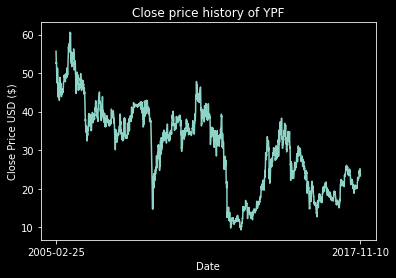

training...


Regression




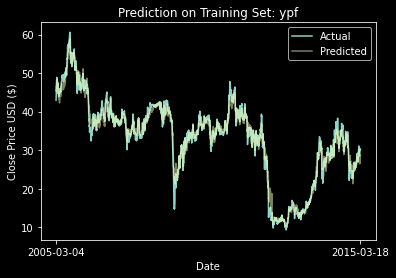

mse value = 1.8062555991221692
mse value = 1.3439700886262942


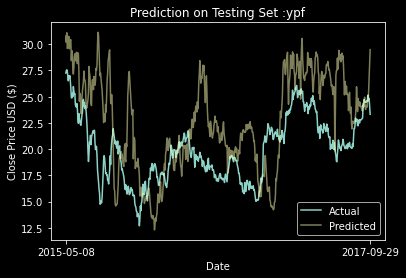

mse value = 22.51505908608284
mse value = 4.745003591788191


CLASSIFICATION


accuracy : 0.3669421487603306
recall : 0.7453183520599251
precision : 0.38715953307393
fscore : 0.5096030729833547
average expected gain : -0.6324843750000009
stock name: ypf, split: 0.8, time step history: t-5, time step future: t+30



<Figure size 432x288 with 0 Axes>

In [ ]:
stock = "ypf"
train_on_stock(stock, 0.8, 5, 1)
train_on_stock(stock, 0.8, 5, 5)
train_on_stock(stock, 0.8, 5, 30)

### **4. AAPL DIRECTION**

In [ ]:
display(table)